# Notes

1. Extract data from Port Buffer (Do not re-run)
2. Create Routes p1
3. Create Routes p2 and Validate Vessel Information
4. Update Departures Draught Info Update Departures Draught Info
5. Extract to Local
6. <b>Trade Estimation (Local)</b>

Setup: Local python environment

We estimate the cargo / load volume using two methodologies: 1) Volume Displacement Method, 2) Draught Ratio method, and then compute the net trade flow. 

# Initializers

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
pd.set_option("display.max_columns", None)  # Show all columns in pandas df
pd.set_option("display.max_rows", 100)  # Show 100 rows in pandas df
# pd.options.display.float_format = '{:.10f}'.format #Show float with 10 decimal points in pandas df

from IPython.core.interactiveshell import (
    InteractiveShell,
)  # allow multiple outputs in one jupyter cell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# df = pd.read_pickle(r'C:\Users\WB514197\WBG\EEAPV Pacific Observatory Files - Geospatial and Big Data\AIS\all-port-statistics\output\Trade Estimation All.pkl')
# keep_cols_final = df.columns

In [4]:
rho = 1.025  # density of salt water
ballast_ratio = 0.55  # percentage of ballast water in Deadweight Tonnage

# Get Trade Related Port Calls

Using Ship Register vessel categories, keep only routes from vessels that are "Cargo Carrying" and not "Passenger" or "Landing Craft"


Remove domestic routes

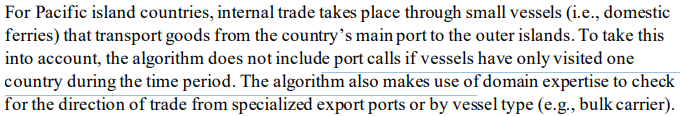

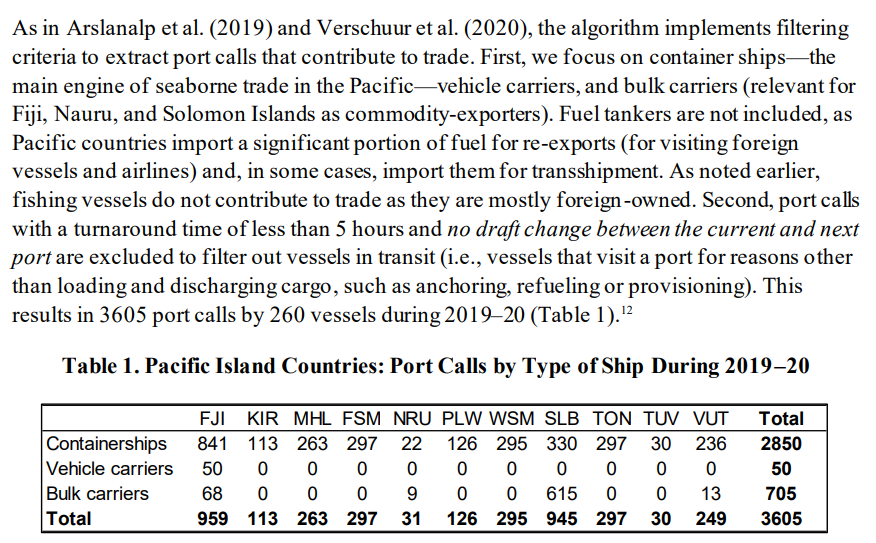

In [5]:
# imf = pd.read_csv("../port_calls_5h_draught_corrected_final.csv")
# imf.columns


# # keep also vessels in IMF per country to ensure that we don't miss any for comparison later
# imf = imf[['mmsi','country_enter','port_enter']] \
#             .drop_duplicates() \
#             .rename(columns={'country_enter':'Country','port_enter':'Port'})
# imf['in_imf']=True

In [7]:
os.listdir(".")  # output

['01-data-extraction.ipynb',
 '02-aggregate-routes.ipynb',
 '03-next-draught.ipynb',
 '04-trade-estimation.ipynb',
 'Syria.csv']

In [8]:
files = ["Syria.csv"]

In [9]:
# once intl, always intl
df = pd.concat([pd.read_csv("./" + x) for x in files], ignore_index=True).drop(
    columns=["Unnamed: 0"]
)


# df['in_imf'] = df[['mmsi','Country','Port']].merge(imf, how="left")['in_imf'].fillna(False)

print(f"All port calls: {df.shape[0]:,}")

cond = (
    (df["ShiptypeLevel1"] == "Cargo Carrying")
    & (df["SubGroup"] != "Passenger")
    & (df["SubType"] != "Landing Craft")
)
print(f"Cargo Carrying: {df[cond].shape[0]:,}")


intl_vessels = df[df["country_count"] > 0][["mmsi", "imo"]].drop_duplicates()
intl_vessels["intl"] = True

df["intl"] = df.merge(intl_vessels, how="left")["intl"].fillna(False)

print(f"Cargo Carrying Not Domestic: {df[cond & df['intl']].shape[0]:,}")

# print(f"Cargo Carrying Not Domestic OR in IMF: {df[(cond & df['intl']) | df['in_imf']].shape[0]:,}")

All port calls: 1,516
Cargo Carrying: 1,490
Cargo Carrying Not Domestic: 1,365


In [10]:
df = df[(cond & df["intl"])].reset_index().rename(columns={"index": "id"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   level_0                    1365 non-null   int64  
 1   id                         1365 non-null   int64  
 2   mmsi                       1365 non-null   float64
 3   imo                        1365 non-null   float64
 4   vessel_name                1365 non-null   object 
 5   new_route_group            1365 non-null   float64
 6   Port                       1365 non-null   object 
 7   length                     1365 non-null   float64
 8   width                      1365 non-null   float64
 9   vessel_type                1365 non-null   object 
 10  arrival_dt_pos_utc         1365 non-null   object 
 11  arrival_draught            1365 non-null   float64
 12  arrival_destination        1354 non-null   object 
 13  count_ais                  1365 non-null   float

In [11]:
# # next countries should be intl
# # All port calls: 43,199
# # Cargo Carrying: 20,657
# # Cargo Carrying Not Domestic: 6,708

# df = pd.concat([pd.read_csv("output/" + x) for x in files], ignore_index=True).drop(columns=['Unnamed: 0'])

# print(f"All port calls: {df.shape[0]:,}")

# cond = (df['ShiptypeLevel1'] == 'Cargo Carrying') & (df['SubGroup'] != "Passenger") & (df['SubType'] != "Landing Craft")
# print(f"Cargo Carrying: {df[cond].shape[0]:,}")

# cond2 = df['country_count']>0

# print(f"Cargo Carrying Not Domestic: {df[cond & cond2].shape[0]:,}")

# df = df[cond & cond2].reset_index().rename(columns={'index':'id'})
# # df.info()

In [12]:
## Clean improper values
keep_cols = [
    "length",
    "width",
    "Draught",
    "Displacement",
    "LightDisplacementTonnage",
    "LengthOverallLOA",
    "LengthRegistered",
    "BreadthExtreme",
    "BreadthMoulded",
    "arrival_draught",
    "departure_draught",
]
df[keep_cols].info()
df[keep_cols].replace(0, np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   length                    1365 non-null   float64
 1   width                     1365 non-null   float64
 2   Draught                   1365 non-null   float64
 3   Displacement              1365 non-null   float64
 4   LightDisplacementTonnage  1365 non-null   float64
 5   LengthOverallLOA          1365 non-null   float64
 6   LengthRegistered          1365 non-null   float64
 7   BreadthExtreme            1365 non-null   float64
 8   BreadthMoulded            1365 non-null   float64
 9   arrival_draught           1365 non-null   float64
 10  departure_draught         1365 non-null   float64
dtypes: float64(11)
memory usage: 117.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 11 columns):
 #   Column                 

In [13]:
# replace 0 with null
df[keep_cols] = df[keep_cols].replace(0, np.nan)

In [14]:
df["length_final"] = (
    df["LengthOverallLOA"].fillna(df["LengthRegistered"]).fillna(df["length"])
)
df["width_final"] = df["BreadthMoulded"].fillna(df["width"])

In [15]:
df[["length_final", "width_final"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   length_final  1365 non-null   float64
 1   width_final   1365 non-null   float64
dtypes: float64(2)
memory usage: 21.5 KB


# Volume Displacement Method

We estimate the volume of the load of the ship based on the volume of the displaced water. The volume of the displaced water by the ship is derived from the volume of a rectangular block with the same length and width. The ship's draught or the height of the ship submerged in water is the height of the rectangular block. Since the ship is not rectangular, we reduce this by a factor called block coefficent that is dependent on the ship's draught. To convert volume into weight (in tonnes), we multiply the volume by the density of saltwater.

Source: Arslanalp S., Koepke R., and Verschuur J.. Tracking trade from space: an application to pacific island countries. IMF Working Papers, 2021(225):A001, 2021. URL: https://www.elibrary.imf.org/view/journals/001/2021/225/article-A001-en.xml, doi:10.5089/9781513593531.001.A0014

## Arrival and Departure Draught

For each port call, we check if there are changes in the draught from arrival to departure. If there are none, we get the draught value from the next port call.

In [16]:
# reported draught should not be higher than design draught, otherwise, we set to design draught
df["arrival_draught_final"] = df[["Draught", "arrival_draught"]].min(axis=1)
df["departure_draught_temp"] = df[["Draught", "departure_draught"]].min(axis=1)
df["next_arrival_draught_final"] = df[["Draught", "next_arrival_draught"]].min(axis=1)

In [17]:
# back propate departure draught if there is no change in draught, and there is value in next arrival draught
df["back_prop_flag"] = (df["next_arrival_draught"] > 0) & (
    df["departure_draught_temp"] == df["arrival_draught_final"]
)
df["departure_draught_final"] = np.where(
    df["back_prop_flag"], df["next_arrival_draught_final"], df["departure_draught_temp"]
)

## Design Block Coeffient
From any reported draught $d_r$,  Displacement at reported draught $Disp_r$ can be estimated as the volume of a rectangular block with the same dimensions of the ship. The length and width of the ship represents the length and width of the rectangular block and the draught represents the height. The volume is adjusted by a factor called block coefficient and then converted to tonnes by multiplying by the density of salt watre : $$Disp_r = Cb_r*L*W*\rho*d_r$$

where:
- $Cb_r$ = block coefficient at draught $d_r$
- $L$ = Length
- $W$ = width
- $\rho$ = density of salt water
- $d_r$ = reported draught

We can derive the block coefficent for any given draught as follows: $$Cb_{r} = \frac{Disp_{r}}{L*W*\rho*d_{r}}$$ 

In Ship Register, `Draught` is the design draught or the draught when the ship is loaded at maximum capacity, `Displacement` is the displacement at design draught. 

In [18]:
# compute only for vessels where we have complete values of Displacement, Draught, Length and Width
cond = (
    df[["length_final", "width_final", "Displacement", "Draught"]].isnull().sum(axis=1)
    == 0
)
df["design_bc"] = np.where(
    cond,
    df["Displacement"] / (df["length_final"] * df["width_final"] * rho * df["Draught"]),
    np.nan,
)

When design_bc cannot be derived, instead of referring to the block coefficients published in DHI Vessels Catalogue, we decided to replace with average design block coefficient according to the characteristics of the Ship.

In [19]:
# Ship Type Levels 1 and 2
df[cond][
    ["mmsi", "imo", "ShiptypeLevel1", "ShipTypeLevel2", "design_bc"]
].drop_duplicates().groupby(["ShiptypeLevel1", "ShipTypeLevel2"]).agg(
    {"design_bc": "mean", "mmsi": "count"}
)

design_bc  mmsi
ShiptypeLevel1 ShipTypeLevel2                      
Cargo Carrying Bulk Carriers         0.785115    43
               Dry Cargo/Passenger   0.672274   153
               Tankers               0.822507    13

In [20]:
# Ship Type Levels 1, 2, and 3 -> seems more discrimantory, use as basis
df[cond][
    ["mmsi", "imo", "ShiptypeLevel1", "ShipTypeLevel2", "ShipTypeLevel3", "design_bc"]
].drop_duplicates().groupby(["ShiptypeLevel1", "ShipTypeLevel2", "ShipTypeLevel3"]).agg(
    {"design_bc": "mean", "mmsi": "count"}
)

design_bc  mmsi
ShiptypeLevel1 ShipTypeLevel2      ShipTypeLevel3                  
Cargo Carrying Bulk Carriers       Bulk Dry          0.785115    43
               Dry Cargo/Passenger Container         0.638191    55
                                   General Cargo     0.711099    79
                                   Other Dry Cargo   0.632764     7
                                   Ro-Ro Cargo       0.595946    12
               Tankers             Chemical          0.822507    13

In [21]:
# Average design block coefficients per ship type level
bc_ref_df = (
    df[cond][
        [
            "mmsi",
            "imo",
            "ShiptypeLevel1",
            "ShipTypeLevel2",
            "ShipTypeLevel3",
            "design_bc",
        ]
    ]
    .drop_duplicates()
    .groupby(["ShiptypeLevel1", "ShipTypeLevel2", "ShipTypeLevel3"])
    .agg({"design_bc": "mean", "mmsi": "count"})
)

In [22]:
df["design_bc_ave"] = df[["ShiptypeLevel1", "ShipTypeLevel2", "ShipTypeLevel3"]].merge(
    bc_ref_df.reset_index(), how="left"
)["design_bc"]
df["design_bc_final"] = np.where(~cond, df["design_bc_ave"], df["design_bc"])

In [23]:
# aall ships have design block coefficient
df[df["design_bc_final"].isnull()]

,level_0,id,mmsi,imo,vessel_name,new_route_group,Port,length,width,vessel_type,arrival_dt_pos_utc,arrival_draught,arrival_destination,count_ais,max_sog,min_sog,departure_dt_pos_utc,departure_draught,departure_destination,mean_sog,time_spent,prev_departure_dt_pos_utc,time_travel,year,month,date,StatCode5,ShipName,ExName,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType,match_ihs,ihs_imo,ExName_perdate,ExName_eff_until_date,ihs_mmsi,fin_match,lev_ShipName,lev_ExName,lev_ExName_perdate,next_Country,next_Port,next_arrival_dt,next_arrival_draught,country_list,Country,country_list2,country_count,week,intl,length_final,width_final,arrival_draught_final,departure_draught_temp,next_arrival_draught_final,back_prop_flag,departure_draught_final,design_bc,design_bc_ave,design_bc_final
938,1054,1054,620794000.0,7911595.0,MANASSA FLOWER M,1.0,Al Ladhiqiyah,83.0,13.0,UNAVAILABLE,2021-03-27 22:29:43,6.6,TRIPOLI,5.0,0.2,0.0,2021-03-28 12:04:32,6.6,TRIPOLI,0.10,0 days 13:34:49,NaN,NaN,2021,3,2021-03-27,A24D2BA,DALIA,Sea Mercy,2340.0,3241.0,80.9,NaN,162.0,13.52,13.5,NaN,6.068,NaN,1211.0,Aggregates Carrier,Aggregates Carrier,Other Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Aggregates Carrier,imo,7911595.0,Manassa Flower M,2022-08-01,511100849.0,okay - match ship name,0.875,0.6875,0.0,Turkey,Yakacik,2021-06-04 18:34:49,5.0,['Turkey'],Syria,['Turkey'],1,12,True,80.9,13.5,6.068,6.068,5.000,True,5.0,NaN,NaN,NaN
939,1055,1055,620794000.0,7911595.0,MANASSA FLOWER M,2.0,Tartus,83.0,13.0,Cargo,2022-05-09 08:16:15,4.0,TARTUS,12.0,0.2,0.0,2022-05-14 05:48:44,4.0,TARTUS,0.05,4 days 21:32:29,2021-03-28 12:04:32,406 days 20:11:43,2022,5,2022-05-09,A24D2BA,DALIA,Sea Mercy,2340.0,3241.0,80.9,NaN,162.0,13.52,13.5,NaN,6.068,NaN,1211.0,Aggregates Carrier,Aggregates Carrier,Other Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Aggregates Carrier,imo,7911595.0,Manassa Flower M,2022-08-01,511100849.0,okay - match ship name,0.875,0.6875,0.0,NaN,NaN,NaN,NaN,NaN,Syria,NaN,0,19,True,80.9,13.5,4.000,4.000,6.068,False,4.0,NaN,NaN,NaN


## Block Coefficient at Reported Draught

Given design draught, and design block coeffient, the block coefficient at reported draught can be estimated as: $$ Cb_r = 1 - (1 - Cb_d) \frac{d_d}{d_r} ^ \frac{1}{3} $$

Source: MAN Diesel & Turbo. Basic Principles of Ship Propulsion” by MAN Diesel & Turbo. URL: https://marengine.com/ufiles/MAN-Basic_Principles_of_Ship_Propulsion.pdf

In [24]:
# Will result to null if any of the draughts are null
df["arrival_bc_final"] = 1 - (1 - df["design_bc_final"]) * (
    df["Draught"] / df["arrival_draught_final"]
) ** (1 / 3)
df["departure_bc_final"] = 1 - (1 - df["design_bc_final"]) * (
    df["Draught"] / df["departure_draught_final"]
) ** (1 / 3)

## Compute trade based on displacement

From the Variable Lightweight Model: $$LWT + DWT = Disp_{design} $$

where:

- $LWT$ = Lightweight Tonnage, displacement when ship is empty, i.e., minimum displacement. In Ship Register, this is Light Displacement Tonnage
- $DWT$ = Deadweight Tonnage, displacement due to maximum load, e.g. cargo, fuel, ballast water, etc. In Ship Register, this is Deadweight
- $Disp_design$ = Tonnage at Displacement from Draught_r (Displacement in Ship Register)

Source: Jia H., Prakash H., and Smith T.. Estimating vessel payloads in bulk shipping using ais data. International Journal of Shipping and Transport Logistics, 11:25, 01 2019. doi:10.1504/IJSTL.2019.0968648.

In [25]:
# Displacement at reported draught
df["arrival_disp"] = (
    df["arrival_bc_final"]
    * df["length_final"]
    * df["width_final"]
    * df["arrival_draught_final"]
    * rho
)
df["departure_disp"] = (
    df["departure_bc_final"]
    * df["length_final"]
    * df["width_final"]
    * df["departure_draught_final"]
    * rho
)

# arrival, departure displacement should be at least lightweight
df["arrival_disp_final"] = df[["Displacement", "arrival_disp"]].min(axis=1)
df["departure_disp_final"] = df[["Displacement", "departure_disp"]].min(axis=1)

df["trade_flow"] = df["departure_disp_final"] - df["arrival_disp_final"]

# if there is no change in draft, even if arrival and departure displacement cannnot be computed, trade flow is still 0
df["trade_flow"] = np.where(
    df["departure_draught_final"] - df["arrival_draught_final"] == 0,
    0,
    df["trade_flow"],
)

## Override trade flow with average
If there are no changes in draft even after back-propagation, for each vessel and port, we get the average trade flow of routes with changes and then assign the average to those without changes. 

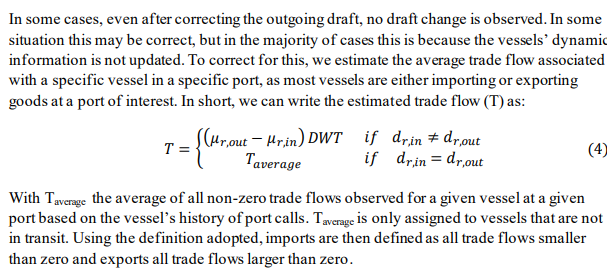

In [26]:
df["lightweight"] = df["Displacement"] - df["Deadweight"]
df["arrival_util"] = (df["arrival_disp_final"] - df["lightweight"]) / df["Deadweight"]
df["departure_util"] = (df["departure_disp_final"] - df["lightweight"]) / df[
    "Deadweight"
]

df["net_util_rate"] = df["departure_util"] - df["arrival_util"]

df["trade_override_flag"] = (df["trade_flow"] == 0) | df["net_util_rate"].isnull()
df[~df["trade_override_flag"]][["arrival_util", "departure_util"]].describe()

,arrival_util,departure_util
count,738.000000,738.000000
mean,0.844871,0.763675
std,0.158445,0.170965
min,-0.275757,0.219614
25%,0.768559,0.655629
50%,0.877433,0.795925
75%,0.977773,0.891832
max,1.000000,1.000000


In [27]:
trade_flow_df = (
    df[~df["trade_override_flag"]]
    .groupby(["Country", "Port", "mmsi", "imo"])["trade_flow"]
    .mean()
    .reset_index()
)
trade_flow_df

,Country,Port,mmsi,imo,trade_flow
0,Syria,Al Ladhiqiyah,209279000.0,9232163.0,-6921.083249
1,Syria,Al Ladhiqiyah,210698000.0,9232151.0,-7443.493625
2,Syria,Al Ladhiqiyah,211182720.0,9155365.0,-1248.083012
3,Syria,Al Ladhiqiyah,215179000.0,9226504.0,-719.283617
4,Syria,Al Ladhiqiyah,215417000.0,9379349.0,707.007540
...,...,...,...,...,...
196,Syria,Tartus,671782000.0,9128427.0,-5071.405730
197,Syria,Tartus,671954000.0,8909446.0,-324.344191
198,Syria,Tartus,677023300.0,9000728.0,-1216.390228
199,Syria,Tartus,677030700.0,7223041.0,435.164813


In [28]:
df["trade_flow_ave"] = df[["Country", "Port", "mmsi", "imo"]].merge(
    trade_flow_df, how="left"
)["trade_flow"]
df["trade_flow_final"] = np.where(
    df["trade_override_flag"], df["trade_flow_ave"], df["trade_flow"]
)
df["trade_flow_final"] = df["trade_flow_final"].fillna(df["trade_flow"])

In [29]:
df.shape

(1365, 91)

In [30]:
# No trade flow
# there is change in draft, but design draught not available

df[df["trade_flow_final"].isnull()][
    [
        "Country",
        "Port",
        "vessel_name",
        "imo",
        "mmsi",
        "SubType",
        "ShipTypeLevel3",
        "length_final",
        "width_final",
        "Draught",
        "Displacement",
        "design_bc_final",
        "arrival_bc_final",
        "departure_disp",
        "arrival_draught_final",
        "departure_draught_final",
        "trade_flow_ave",
        "trade_flow",
    ]
]

,Country,Port,vessel_name,imo,mmsi,SubType,ShipTypeLevel3,length_final,width_final,Draught,Displacement,design_bc_final,arrival_bc_final,departure_disp,arrival_draught_final,departure_draught_final,trade_flow_ave,trade_flow
938,Syria,Al Ladhiqiyah,MANASSA FLOWER M,7911595.0,620794000.0,Aggregates Carrier,Other Bulk Dry,80.9,13.5,6.068,NaN,NaN,NaN,NaN,6.068,5.0,NaN,NaN


# Save

In [31]:
df.loc[:, "Type"] = df.apply(
    lambda x: "Exports" if x["trade_flow_final"] > 0 else "Imports", axis=1
)
# df.loc[df['net_cargo_final'] < 0, 'Type'] = 'Export'

In [32]:
df_template = pd.read_csv(
    r"C:\Users\WB514197\WBG\EEAPV Pacific Observatory Files - Geospatial and Big Data\AIS\all-port-statistics\output\Trade Estimation All.csv"
)
keep_cols_template = df_template.columns

In [36]:
df.loc[:, "trade_flow_final_abs"] = df["trade_flow_final"].abs()

In [40]:
keep_cols_template

Index(['id', 'Country', 'Port', 'mmsi', 'imo', 'vessel_name', 'ShiptypeLevel5',
       'ShipTypeLevel4', 'ShipTypeLevel3', 'ShipTypeLevel2', 'ShiptypeLevel1',
       'SubType', 'SubGroup', 'arrival_dt_pos_utc', 'departure_dt_pos_utc',
       'arrival_draught_final', 'departure_draught_final', 'trade_flow_final',
       'Type', 'time_spent', 'gt_5hrs', 'same_draught_next', 'transshipment',
       'imf_ass'],
      dtype='object')

In [33]:
cols = list(keep_cols_template[0:-5]) + ["year", "month", "week", "date"]

In [42]:
# df[cols].to_csv("./Trade_Estimation_Syria_10.15.24.csv")
df.to_csv("./Trade_Estimation_Syria_10.15.24.csv")

In [44]:
df.loc[:, "ym"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)

In [77]:
group_cols = ["Country", "Port", "year", "month", "ym", "Type"]  # "ShipTypeLevel2"
data_cols = ["trade_flow_final_abs"]

In [92]:
df_agg = df.groupby(group_cols)[data_cols].sum().reset_index()

In [93]:
df_all = (
    df.groupby(["Country", "year", "month", "ym", "Type"])[data_cols]
    .sum()
    .reset_index()
    .assign(Port="Syria")
)

In [94]:
df_all = pd.concat([df_agg, df_all], ignore_index=True)

In [95]:
df_all = (
    df_all.pivot_table(
        index=["Country", "Port", "year", "month", "ym"],
        columns="Type",
        values="trade_flow_final_abs",
    )
    .reset_index()
    .fillna(0)
)
# .to_csv("./Trade_Estimation_Syria_Monthly.csv", index=False)

In [96]:
df_all.to_csv("./Trade_Estimation_Syria_Monthly.csv", index=False)

In [108]:
# df.iloc[0]

In [115]:
# df.groupby(['year', 'ShipTypeLevel2', 'ShiptypeLevel5', ])[['mmsi']].count()

In [117]:
# count unique mmsi per year and ship type
df_count = (
    df.groupby(
        [
            "year",
            "ShipTypeLevel2",
            "ShiptypeLevel5",
        ]
    )[["mmsi"]]
    .nunique()
    .reset_index()
    .rename(columns={"mmsi": "unique_mmsi"})
)

In [135]:
df_count.rename(
    columns={
        "year": "Year",
        "ShipTypeLevel2": "Ship Type Level 2",
        "ShiptypeLevel5": "Ship Type Level 5",
        "unique_mmsi": "No. of vessels",
    },
    inplace=True,
)

In [138]:
table = (
    df_count.pivot(
        index=["Ship Type Level 2", "Ship Type Level 5"],
        columns="Year",
        values="No. of vessels",
    )
    .fillna(0)
    .reset_index()
    .to_markdown(tablefmt="github", index=False)
)

In [139]:
print(table)

| Ship Type Level 2   | Ship Type Level 5                        |   2019 |   2020 |   2021 |   2022 |   2023 |   2024 |
|---------------------|------------------------------------------|--------|--------|--------|--------|--------|--------|
| Bulk Carriers       | Aggregates Carrier                       |      0 |      0 |      1 |      1 |      0 |      0 |
| Bulk Carriers       | Bulk Carrier                             |     20 |     18 |     11 |      9 |      2 |      0 |
| Dry Cargo/Passenger | Container Ship (Fully Cellular)          |     37 |     29 |     27 |     16 |     17 |     14 |
| Dry Cargo/Passenger | General Cargo Ship                       |     61 |     53 |     37 |     23 |     21 |     12 |
| Dry Cargo/Passenger | General Cargo Ship (Open Hatch)          |      1 |      0 |      2 |      0 |      0 |      0 |
| Dry Cargo/Passenger | General Cargo Ship (with Ro-Ro facility) |      1 |      0 |      0 |      1 |      0 |      1 |
| Dry Cargo/Passenger | Heavy Lo